# Interactive Visual Feature Search
## Domain Generalization with WILDS/iWildCam

This notebook uses Interactive Visual Feature Search to explore the relationship between in-domain and out-of-domain image features for the iWildCam dataset in [WILDS](https://wilds.stanford.edu/).

The question we aim to answer is: "do image features for an image from one domain $d$ generalize well to (i.e. have high similarity scores to) images of the same class from domain $d' \neq d$?" To help answer this question, we use VFS to find the nearest neighbors to any given input region, and we display the top five results across all domains (with duplicates) and unique domains (without duplicates).

## Setup

In [11]:
!wget https://azcopyvnext.azureedge.net/release20220511/azcopy_linux_amd64_10.15.0.tar.gz
!tar -xvf azcopy_linux_amd64_10.15.0.tar.gz

!pip install zarr
!pip install wilds

# download the feature data
!./azcopy_linux_amd64_10.15.0/azcopy copy https://vissearch.blob.core.windows.net/data/IWC_ResNet_Val_09092023_f16.tar.gz IWC_ResNet_Val_09092023_f16.tar.gz
!tar -xzf IWC_ResNet_Val_09092023_f16.tar.gz

# get a pretrained iWildCam model
!wget https://worksheets.codalab.org/rest/bundles/0x7c1e753853f640828f5edc4eb6bb607b/contents/blob/best_model.pth

In [8]:
# TODO: change to regular pip upon release
!pip install -i https://test.pypi.org/simple/ --no-deps visualfeaturesearch==0.0.11

Looking in indexes: https://test.pypi.org/simple/


In [9]:
from collections import OrderedDict
import sys

import wilds
import torch
import torchvision
from torchvision import transforms

import zarr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import visualfeaturesearch as vfs
from visualfeaturesearch.searchtool import CachedSearchTool

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  raise Exception('No GPU available')

## Model and dataset setup

We use a pretrained model from the WILDS paper below, and we also load a cache file that we generated for this search task.

In [12]:
state = torch.load('best_model.pth', map_location=torch.device('cpu'))
state = state['algorithm']
new_state = OrderedDict()
for key, value in state.items():
    new_state[key.replace('model.', '')] = value

model = torchvision.models.resnet50(num_classes=182)
model.load_state_dict(new_state)
model = model.eval().to(device)

model_conv5 = vfs.util.FeatureHook(model, model.layer4[2].conv2)

cache_store = zarr.DirectoryStore('IWC_ResNet_Val_09092023_f16')
cache_root = zarr.group(store=cache_store, overwrite=False)
cache_feats_data = cache_root['conv5']

cached_search_tool = CachedSearchTool(model_conv5, cache_feats_data, device, batch_size=5000)

In [15]:
model_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# note: the dataset download may take several minutes
dataset = wilds.get_dataset(dataset='iwildcam', root_dir='data', download=True)
val_id_set = dataset.get_subset('id_val', transform=model_transform)
val_ood_set = dataset.get_subset('val', transform=model_transform)
val_dataset = torch.utils.data.ConcatDataset([val_id_set, val_ood_set])

val_id_vis = dataset.get_subset('id_val', transform=transforms.Resize((224, 224)))
val_ood_vis = dataset.get_subset('val', transform=transforms.Resize((224, 224)))
val_vis_set = torch.utils.data.ConcatDataset([val_id_vis, val_ood_vis])

You can also download the dataset manually at https://wilds.stanford.edu/downloads.


100%|██████████| 11957420032/11957420032 [33:53<00:00, 5880018.94Byte/s]


Extracting data/iwildcam_v2.0/archive.tar.gz to data/iwildcam_v2.0

It took 36.65 minutes to download and uncompress the dataset.



In [16]:
df = pd.read_csv('data/iwildcam_v2.0/metadata.csv')
df = df[(df['split'] == 'id_val') | (df['split'] == 'val')]
df = df.reset_index()

id_locs = df[df['split'] == 'id_val']['location_remapped'].unique()

## Image Query
These images are of a bird from the same camera trap location (i.e. the same domain $d$). Please highlight a part of the bird to search for.

In [17]:
QUERY_IDXS = list(range(6050, 6150,10))  # error_idxs[np.random.randint(0, len(error_idxs), 10), 0]

model_imgs = [val_dataset[idx][0] for idx in QUERY_IDXS]
query_locs = [val_dataset[idx][2][0].item() for idx in QUERY_IDXS]
vis_imgs = [val_vis_set[idx][0] for idx in QUERY_IDXS]
query_img_urls = [vfs.util.image_to_durl(img) for img in vis_imgs]

highlight_data = None
highlight_index = None
def highlight_callback(data):
    global highlight_data, highlight_index
    if isinstance(data, str): # the data get returned in different formats for Colab and Jupyter notebook
        data = data.rsplit(',', 1)
    highlight_data = data[0]
    highlight_index = int(data[1])
vfs.util.create_callback('highlight_callback', highlight_callback)

vfs.widgets.MultiHighlightWidget(all_urls=query_img_urls, callback_name='highlight_callback')

Note: loading results may take over a minute due to the size of the dataset and the size of the model's features ($14 \times 14$).

In [18]:
assert highlight_data is not None, "Use the widget to highlight an image region"

selected_idx = int(highlight_index)
mask = vfs.util.durl_to_image(highlight_data)

cached_search_tool.set_input_image(model_imgs[selected_idx])

# turn the user's highlighted mask into a 14x14 grayscale array
mask_transform = transforms.Resize(14)
mask_14x14 = mask_transform(mask)
mask_14x14_arr = np.asarray(mask_14x14)[:,:,3] / 255
mask_14x14_arr = np.float32(mask_14x14_arr)

print('Loading results...')
region_sims, region_xs, region_ys = cached_search_tool.compute(mask_14x14_arr)
sim_order = torch.argsort(region_sims, descending=True)
print('Done.')

Loading results...
Done.


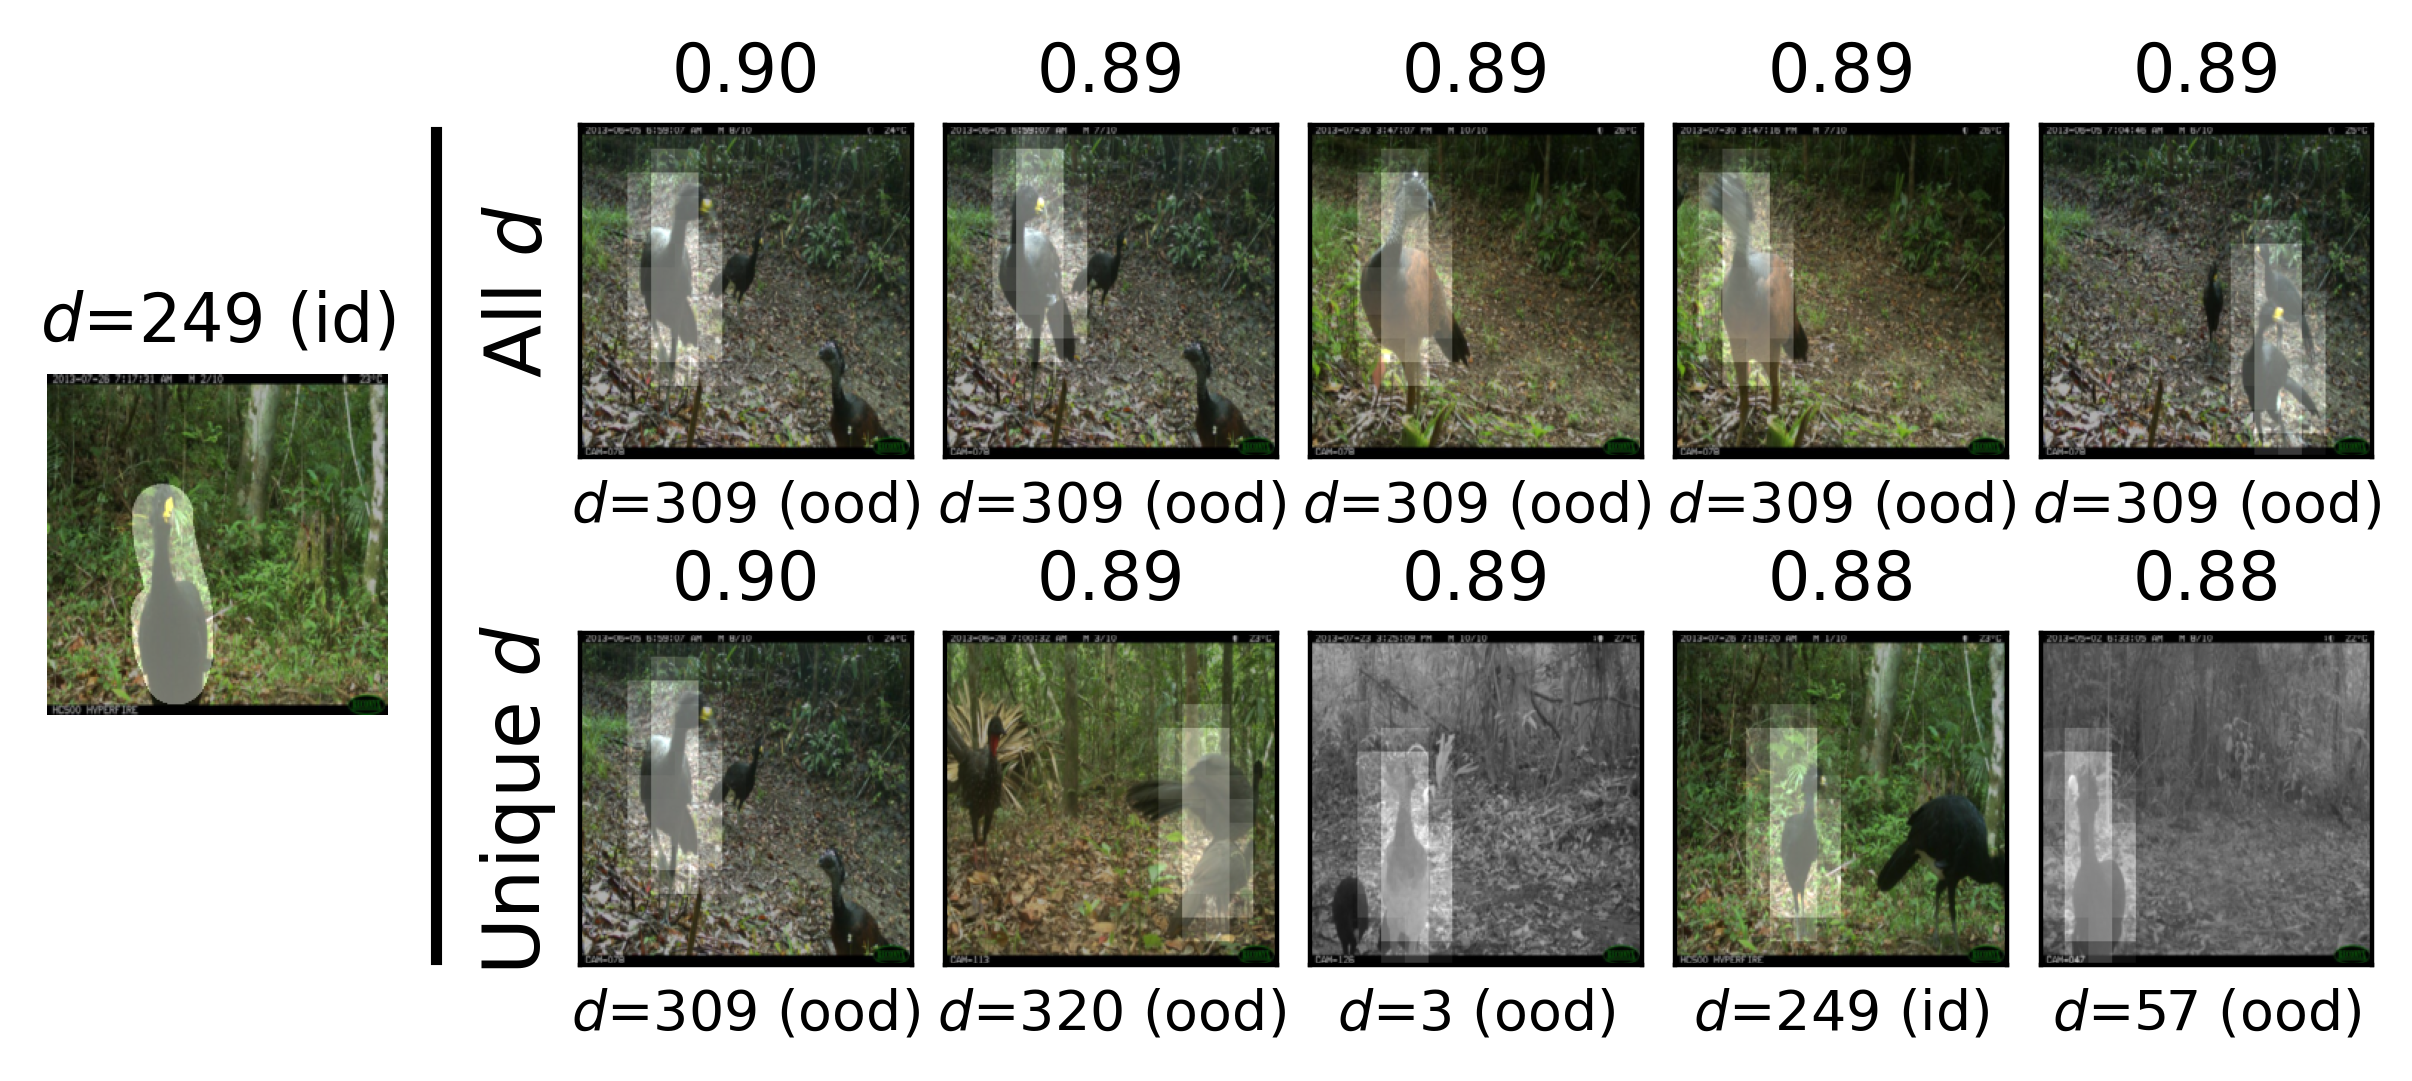

In [19]:
# set up the figure
DISPLAY_NUM = 5

is_animal = False

fig = plt.figure(figsize=(7.5, 3.3), dpi=400)
if is_animal:
    fig.suptitle('All Domains', fontweight='bold', y=0.68, x=0.6)
gs = fig.add_gridspec(1,2, width_ratios=[0.95,5], wspace=0.18)
fig.subplots_adjust(wspace=0.1, hspace=0)
results_gs = gs[1].subgridspec(2,DISPLAY_NUM)

# show the query region on the left-hand side
ax = fig.add_subplot(gs[0])
ax.axis('off')
ax.imshow(vfs.util.mask_overlay(vis_imgs[selected_idx], 0, 0, 224, np.asarray(mask)[:,:,3] / 256))
line_x_val = 255
ax.add_line(matplotlib.lines.Line2D([line_x_val,line_x_val], [-160,224+160], lw=2, color='black')).set_clip_on(False)
is_ood = query_locs[selected_idx] not in id_locs
ax.set_title(f'$d$={query_locs[selected_idx]} ({"ood" if is_ood else "id"})')

# include the most similar images from the dataset on the right side
for i in range(DISPLAY_NUM):
  idx = sim_order[i+1].cpu().numpy()
  curr_example = val_vis_set[idx]
  img = curr_example[0]
  domain = curr_example[2][0].item()

  curr_img_out = vfs.util.mask_overlay(img,
                                   x=region_xs[idx],
                                   y=region_ys[idx],
                                   mask_size=14,
                                   mask=vfs.util.crop_mask(mask_14x14_arr))

  ax = fig.add_subplot(results_gs[i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray')
  ax.set_title( f'{region_sims[idx].cpu().numpy():.02f}')
  is_ood = domain not in id_locs
  ax.set_xlabel(f'$d$={domain} ({"ood" if is_ood else "id"})')
  if i == 0:
    ax.set_ylabel('All $d$', fontsize=14)


# include the most similar images from the dataset on the right side
i = 0
prev_domains = set()
while len(prev_domains) < DISPLAY_NUM:
  idx = sim_order[i+1].cpu().numpy()
  curr_example = val_vis_set[idx]
  img = curr_example[0]
  domain = curr_example[2][0].item()

  i += 1
  if domain in prev_domains:
    continue

  curr_img_out = vfs.util.mask_overlay(img,
                                   x=region_xs[idx],
                                   y=region_ys[idx],
                                   mask_size=14,
                                   mask=vfs.util.crop_mask(mask_14x14_arr))

  ax = fig.add_subplot(results_gs[DISPLAY_NUM + len(prev_domains)])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray')
  ax.set_title( f'{region_sims[idx].cpu().numpy():.02f}')
  is_ood = domain not in id_locs
  ax.set_xlabel(f'$d$={domain} ({"ood" if is_ood else "id"})')
  if len(prev_domains) == 0:
    ax.set_ylabel('Unique $d$', fontsize=14)

  prev_domains.add(domain)

## Results
We display the top five results for all $d$ and unique $d$. Note that the unique $d$ results all contain species of birds within the highlighted regions, and that the similarity scores are relatively high. This indicates that the model has a similar representation between birds of different domains (some of which are out-of-domain and not a part of the training set), which is a good sign for the generalizability of the model.

Try to highlight a background/foliage part of a query image next. Observe that the qualitative and quantitative similarities for search results with unique $d$'s are significantly lower than those when querying for the bird.